# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plot_helper as plh
from inversion_sst_gp import gp_regression as gp_r
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (122.5, 123.75)
LAT_LIMITS = (-14.3, -13.3)  
ll_box = (LON_LIMITS, LAT_LIMITS)
time_str = "2025-05-12T02:00:00"

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', '../', '1_preproc_data', 'non_proc_data', 'himawari', 'himawari_tutorial_01')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [3]:
# Download the data
himawari.get_sst_scene_nasa(time_str, data_dir, overwrite=False)

EarthAccess authenticated: True
Skipping! File already exists and overwrite is False: 20250512010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 501.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:46<00:00, 46.49s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5159.05it/s]


Downloaded and verified: 20250512020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 833.86it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:24<00:00, 24.76s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]

Downloaded and verified: 20250512030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


In [4]:
# Load the data
ds = himawari.process_sst_data(data_dir, time_str, ll_box)
ds

  Starting processing for 2025-05-12T02:00:00
  Finished processing for 2025-05-12T02:00:00


<xarray.Dataset> Size: 22kB
Dimensions:    (lat: 16, lon: 21)
Coordinates:
  * lat        (lat) float64 128B -14.27 -14.21 -14.15 ... -13.49 -13.43 -13.37
  * lon        (lon) float64 168B 122.5 122.6 122.7 122.7 ... 123.6 123.7 123.7
    LON        (lat, lon) float64 3kB 122.5 122.6 122.7 ... 123.6 123.7 123.7
    LAT        (lat, lon) float64 3kB -14.27 -14.27 -14.27 ... -13.37 -13.37
    X          (lat, lon) float64 3kB -6.474e+04 -5.827e+04 ... 6.499e+04
    Y          (lat, lon) float64 3kB -4.979e+04 -4.979e+04 ... 4.979e+04
    lonc       float64 8B 123.1
    latc       float64 8B -13.82
    time       <U19 76B '2025-05-12T02:00:00'
    time_step  int64 8B 3600
Data variables:
    T          (lat, lon) float64 3kB 30.05 30.06 30.08 ... 29.06 29.11 29.14
    dTdt       (lat, lon) float64 3kB 8.75e-05 8.92e-05 ... 1.79e-05 1.62e-05
    dTdx       (lat, lon) float64 3kB 1.031e-06 1.888e-06 ... 4.788e-06
    dTdy       (lat, lon) float64 3kB -2.36e-05 -2.678e-05 ... 1.121e-05

In [5]:
# Compute gradients
time_step = ds.time_step.item()
lon, lat, To, dTdto = (ds[var].values for var in ("lon", "lat", "T", "dTdt"))
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)

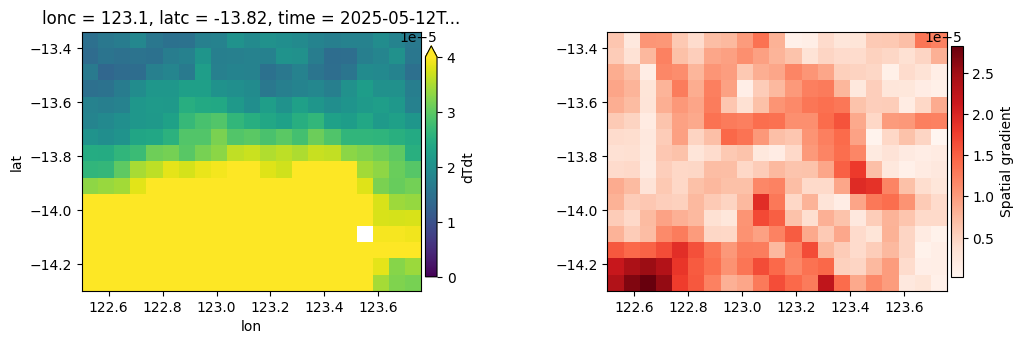

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace':0.3})
ds['dTdt'].plot(ax=ax[0], cmap='viridis', vmin=0, vmax = 4e-5, cbar_kwargs={'pad':0.01, 'shrink':0.5})
C = ax[1].pcolormesh(lon, lat, np.abs(dTds1o+1j*dTds2o), cmap='Reds')
fig.colorbar(C, ax=ax[1], pad=0.01, shrink=0.5, label='Spatial gradient')

for x in ax:
    x.set_aspect('equal')

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

Calculating GP regression prediction


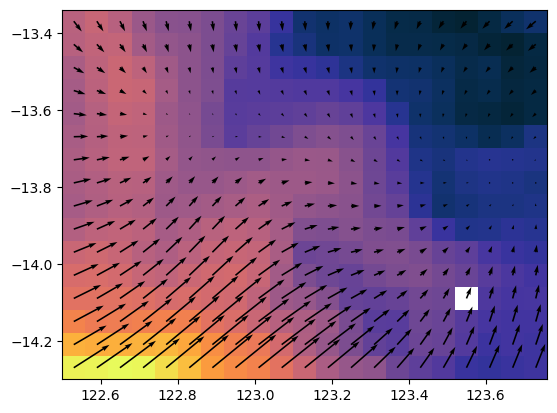

In [7]:
guess_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_v": 9e-2,
    "l_v": 3e4,
    "tau_v": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}

print("Calculating GP regression prediction")
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (gp_r.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, guess_params, X, Y, time_step))

# Plot the mean estimation
plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(lon, lat, To, cmap='cmo.thermal')

plt.quiver(LON, LAT, muustar, muvstar, ) # scale_units='xy', scale=2e-5
ax.set_aspect('equal')

---
# Run the parameter optimization

In [8]:
# Set model hyperparameters
initial_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}
penalty_params = {
    "l_u": [3e4, 0.5e4],
    "sigma_u": [9e-2, 2e-2],
    "tau_u": [1e-2, 0.1e-2],
    "l_S": [2e4, 2e4],
    "sigma_S": [3e-7, 5e-6],
    "tau_S": [2e-7, 5e-6],
}
bounds_params = {
    "sigma_u": [1e-10, 10],
    "l_u": [1, 1e6],
    "tau_u": [1e-10, 1],
    "sigma_S": [1e-8, 1e-3],
    "l_S": [1, 1e6],
    "tau_S": [1e-15, 1e-3],
    "sigma_tau": [1e-15, 1],
}
prop_sat = {
    "initial_params": initial_params,
    "const_params": {},
    "penalty_params": penalty_params,
    "share_len": True,
    "share_tau": True,
    "share_sigma": True,
    "solve_log": True,
    "bounds_params": bounds_params,
}

# Metric functions
def run_gprm_optim(time_str, dTds1, dTds2, dTdt, X, Y, tstep, prop, callback="on"):
    mask = np.ones_like(X, dtype=bool)
    gprm = gp_r.GPRegressionJoint(dTds1, dTds2, dTdt, tstep, X, Y, mask)
    est_params = gprm.estimate_params(**prop, callback=callback)
    return {
        "step": time_str,
        "est_params": est_params,
    }

# Run model
print("Running GP optimization")
tstep = time_step
results = run_gprm_optim(
    time_str, dTds1o, dTds2o, dTdto, X, Y, tstep, prop_sat
)

results

Running GP optimization
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          3012.4     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01        

{'step': '2025-05-12T02:00:00',
 'est_params': {'sigma_u': np.float64(0.11693771374875919),
  'l_u': np.float64(21887.912433918635),
  'tau_u': np.float64(0.010054905605886457),
  'sigma_S': np.float64(1.4571894720537142e-05),
  'l_S': np.float64(41404.87283632045),
  'tau_S': np.float64(2.521689092075618e-07),
  'sigma_tau': np.float64(0.00378815968099505),
  'l_v': np.float64(21887.912433918635),
  'sigma_v': np.float64(0.11693771374875919),
  'tau_v': np.float64(0.010054905605886457)}}

Calculating GP regression prediction


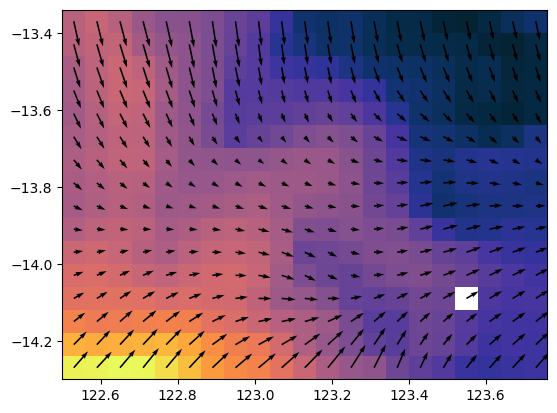

In [9]:
print("Calculating GP regression prediction")
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_r.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, results['est_params'], X, Y, time_step)
)

plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(lon, lat, To, cmap='cmo.thermal')

plt.quiver(LON, LAT, muustar, muvstar) # scale_units='xy', scale=2e-5
ax.set_aspect('equal')